In [1]:
import torch
from torch.utils.data import DataLoader
from dataset import YoloDarknetDataset
from torchvision import transforms
import os
import lightnet as ln
from test_script import test_step
from utils import draw_bounding_boxes, mean_average_precision, to_pixel_coords
from lightnet.util import iou_cwh, iou_tlwh

/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TEST_IMG_DIR = "data/data_split/test/images"
TEST_LABEL_DIR =  "data/data_split/test/labels"
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3

print(f"Using Device {DEVICE}")

model = ln.models.YoloV2(NUM_CLASSES)
model.load('models/5_epochs_split.pt', strict=False)
model.to(DEVICE)

loss_fn = ln.network.loss.RegionLoss(
    num_classes= model.num_classes,
    anchors=model.anchors,
    network_stride=model.stride
)

test_transforms = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor()
])

test_dataset = YoloDarknetDataset(
    images_dir=TEST_IMG_DIR,
    labels_dir=TEST_LABEL_DIR,
    classes=["Cyclist", "Pedestrian", "Car"],
    transform=test_transforms,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Using Device cuda


/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/lightnet/network/module/_lightnet.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

In [3]:
do_test = False
if do_test:
    test_step(
        model=model,
        dataloader=test_dataloader,
        loss_fn=loss_fn,
        device=DEVICE
    )

In [4]:
model_2 = ln.models.YoloV2(NUM_CLASSES)
model_2.load('models/5_epochs_split.pt', strict=False)
model_2.to(DEVICE)

YoloV2(
  (backbone): FeatureExtractor(
    selection=[17_convbatch], return=True
    (module): Sequential(
      (1_convbatch): Conv2dBatchAct(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (2_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3_convbatch): Conv2dBatchAct(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (4_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5_convbatch): Conv2dBatchAct(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (6_convbatch): Conv2dBatchAct(128, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), LeakyReLU(negative_slope=0.1, inplace=True))
      (7_convbatch): Conv2dBatchAct(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), LeakyReLU(negative_slope=0.1, inplace=True))
      (8_m

In [5]:
GetBoxes_fn = ln.data.transform.GetAnchorBoxes(
                conf_thresh=0.5,
                network_stride=model.stride,
                anchors=model.anchors
            )

nms_fn = ln.data.transform.NMS(
    iou_thresh=.3,
    class_nms=True
)

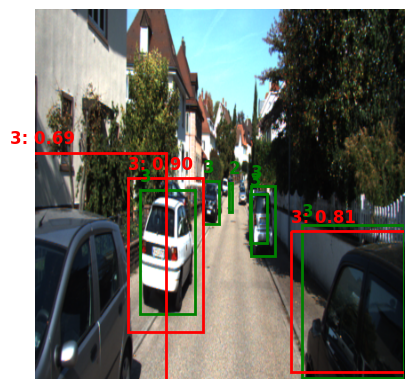

In [98]:
# good indexes: 785, 512, 1023

draw_bounding_boxes(index=3, 
                    model=model_2, 
                    dataset=test_dataset, 
                    GetBoxes_fn=GetBoxes_fn, 
                    nms_fn=nms_fn, 
                    class_names=["1", "2", "3"], 
                    device=DEVICE)

In [91]:
# INPUT IS A BATCH
true_boxes = []
pred_boxes = []
batch_index = 0
for index, (X, y) in enumerate(test_dataloader):
    batch_size = len(y["boxes"])
    model_input = X.to(DEVICE)
    model_2.to(DEVICE)
    model_2.eval()

    with torch.inference_mode():
        model_output = model_2(model_input)

    box_tensor = GetBoxes_fn(model_output.cpu())
    output_boxes = nms_fn(box_tensor)
    for img_index, boxes in enumerate(y["boxes"]):
        for box in boxes:
            if box[0].item() == -1: #supress the padding
                continue
            #x1, y1, x2, y2 = box[1:]
            x1, y1, x2, y2 = to_pixel_coords(box[1:], 416, 416)
            # add image index on the list
            
            true_box = [img_index+index*batch_size, box[0].item(), 1, x1.item(), y1.item(), x2.item(), y2.item()] 
            true_boxes.append(true_box)
        
    for bbox in output_boxes:
        x1, y1, x2, y2 = to_pixel_coords(bbox[1:5], 1, 1)
        #x1, y1, x2, y2 = bbox[1:5]
       
        pred_box = [bbox[0].item()+index*batch_size, 
        bbox[6].item(), 
        bbox[5].item() , 
        x1.item(), 
        y1.item(),
        x2.item(), 
        y2.item()]

        pred_boxes.append(pred_box)
   
    if index == batch_index:
        break
    
pred_boxes = sorted(pred_boxes, key=lambda x: x[0])

In [83]:
pred_boxes, len(pred_boxes)

([[0.0,
   2.0,
   0.684019148349762,
   222.7008819580078,
   210.47402954101562,
   13.48870849609375,
   42.4833984375],
  [2.0,
   2.0,
   0.6692216396331787,
   123.65040588378906,
   202.86817932128906,
   18.302398681640625,
   26.256011962890625],
  [3.0,
   2.0,
   0.9044978618621826,
   104.89224243164062,
   189.84713745117188,
   84.5435791015625,
   173.28533935546875],
  [3.0,
   2.0,
   0.8125756978988647,
   287.7974853515625,
   249.02532958984375,
   141.1634521484375,
   158.87640380859375],
  [3.0,
   2.0,
   0.6920294761657715,
   -28.345855712890625,
   160.75074768066406,
   175.27919006347656,
   300.58856201171875],
  [5.0,
   2.0,
   0.6412906050682068,
   -13.379890441894531,
   222.56329345703125,
   145.1572265625,
   177.8311767578125],
  [5.0,
   2.0,
   0.5976399183273315,
   122.59062194824219,
   220.19813537597656,
   42.485076904296875,
   80.69352722167969],
  [6.0,
   2.0,
   0.8993797302246094,
   4.147167205810547,
   200.85496520996094,
   46.29

In [92]:
true_boxes

[[0,
  2.0,
  1,
  220.1885986328125,
  210.91754150390625,
  14.29541015625,
  36.896453857421875],
 [1,
  0.0,
  1,
  110.5514907836914,
  198.28224182128906,
  10.286125183105469,
  66.44908142089844],
 [2,
  2.0,
  1,
  124.91722869873047,
  202.60862731933594,
  13.149879455566406,
  25.559036254882812],
 [2,
  1.0,
  1,
  227.07168579101562,
  182.64064025878906,
  4.3241424560546875,
  34.078704833984375],
 [3,
  2.0,
  1,
  300.1463623046875,
  242.0232696533203,
  115.51870727539062,
  172.86741638183594],
 [3,
  2.0,
  1,
  117.84657287597656,
  203.21878051757812,
  62.27606201171875,
  139.16586303710938],
 [3,
  2.0,
  1,
  188.3990936279297,
  192.42494201660156,
  18.760208129882812,
  48.699737548828125],
 [3,
  2.0,
  1,
  242.5695343017578,
  198.4708251953125,
  27.190719604492188,
  78.79592895507812],
 [3,
  1.0,
  1,
  217.77700805664062,
  194.6103515625,
  3.2824249267578125,
  33.02485656738281],
 [3,
  2.0,
  1,
  241.43072509765625,
  207.45643615722656,
  19

In [85]:
mean_average_precision(pred_boxes=pred_boxes, true_boxes=true_boxes, iou_threshold=0.5, box_format="corners", num_classes=3)

(tensor(0.), [tensor(0.), tensor(0.), tensor(0.)])

In [ ]:
import numpy as np
from collections import defaultdict

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    
    Args:
        box1 (list): [x1, y1, x2, y2] coordinates of the first box.
        box2 (list): [x1, y1, x2, y2] coordinates of the second box.
    
    Returns:
        float: IoU value.
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Calculate union
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0

def calculate_map(pred_boxes, true_boxes, iou_threshold=0.5, num_classes=3):
    """
    Calculate mean Average Precision (mAP) for object detection.

    Args:
        pred_boxes (list): List of predicted boxes, each in the format 
                           [image_index, class_prediction, probability_score, x1, y1, x2, y2].
        true_boxes (list): List of ground truth boxes, each in the format 
                           [image_index, class_prediction, 1, x1, y1, x2, y2].
        iou_threshold (float): IoU threshold to determine a correct prediction.
        num_classes (int): Number of classes.

    Returns:
        float: mAP value.
        dict: Average precision (AP) per class.
    """
    # Separate predictions by class
    average_precisions = {}
    epsilon = 1e-6

    for c in range(num_classes):
        # Filter predictions and true boxes for the current class
        pred_class_boxes = [box for box in pred_boxes if box[1] == c]
        true_class_boxes = [box for box in true_boxes if box[1] == c]

        # Count the number of ground truth boxes per image for this class
        image_gt_count = defaultdict(int)
        for box in true_class_boxes:
            image_gt_count[box[0]] += 1

        # Track which ground truth boxes have been detected
        image_gt_detected = {img_idx: [False] * count for img_idx, count in image_gt_count.items()}

        # Sort predictions by confidence score in descending order
        pred_class_boxes.sort(key=lambda x: x[2], reverse=True)

        true_positives = []
        false_positives = []
        for pred_box in pred_class_boxes:
            img_idx, _, prob, x1, y1, x2, y2 = pred_box
            best_iou = 0
            best_gt_idx = -1

            # Check against all ground truth boxes in the same image
            for gt_idx, gt_box in enumerate([box for box in true_class_boxes if box[0] == img_idx]):
                iou = calculate_iou(pred_box[3:], gt_box[3:])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx

            # If IoU exceeds threshold and ground truth is not already detected
            if best_iou > iou_threshold:
                if not image_gt_detected[img_idx][best_gt_idx]:
                    true_positives.append(1)
                    false_positives.append(0)
                    image_gt_detected[img_idx][best_gt_idx] = True
                else:
                    true_positives.append(0)
                    false_positives.append(1)
            else:
                true_positives.append(0)
                false_positives.append(1)

        # Compute cumulative true positives and false positives
        tp_cumsum = np.cumsum(true_positives)
        fp_cumsum = np.cumsum(false_positives)
        
        # Calculate precision and recall
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + epsilon)
        recalls = tp_cumsum / (sum(image_gt_count.values()) + epsilon)
        
        # Calculate Average Precision (AP)
        precisions = np.concatenate(([0], precisions, [0]))
        recalls = np.concatenate(([0], recalls, [1]))
        for i in range(len(precisions) - 1, 0, -1):
            precisions[i - 1] = max(precisions[i - 1], precisions[i])
        indices = np.where(recalls[1:] != recalls[:-1])[0]
        ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
        average_precisions[c] = ap

    # Calculate mAP
    mean_ap = np.mean(list(average_precisions.values()))
    return mean_ap, average_precisions


In [84]:
# Example predictions and ground truths

iou_threshold = 0.5
num_classes = 3

mean_ap, aps = calculate_map(pred_boxes, true_boxes, iou_threshold, num_classes)
print("Mean Average Precision (mAP):", mean_ap)
print("Average Precision per class:", aps)


Mean Average Precision (mAP): 0.0
Average Precision per class: {0: np.float64(0.0), 1: np.float64(0.0), 2: np.float64(0.0)}


In [89]:
# Example predictions and ground truths
pred_boxes = [
    [0, 0, 0.9, 50, 50, 100, 100],  # [image_idx, class_id, confidence, x1, y1, x2, y2]
    [0, 0, 0.8, 55, 60, 105, 110],
    [1, 1, 0.75, 25, 30, 75, 80]
]
true_boxes = [
    [0, 0, 1, 50, 50, 100, 100],
    [1, 1, 1, 25, 30, 75, 80]
]

iou_threshold = 0.5
num_classes = 2

mean_ap, aps = calculate_map(pred_boxes, true_boxes, iou_threshold, num_classes)
print("Mean Average Precision (mAP):", mean_ap)
print("Average Precision per class:", aps)


Mean Average Precision (mAP): 0.9999980000030001
Average Precision per class: {0: np.float64(0.9999980000030001), 1: np.float64(0.9999980000030001)}
